## R-Script Hidden Markov Models

This is run with an R kernel instead of a python kernel in Jupyter Notebook.

More reading:

- https://cran.r-project.org/web/packages/moveHMM/vignettes/moveHMM-guide.pdf
- https://stackoverflow.com/questions/57870575/install-and-run-r-kernel-for-jupyter-notebook


The goal for this notebook is to take the prepped GPS data from the 01-GPS PreProcessing notebook and then to use that to fit multiple different HMM that represent the deer movement model. Different numbers of behavioural states, and different landscape rasters are used to fit the HMM. 

The different models are tested using Akaike's Information Criteriont (AIC) and Bayesian Information Criterion (BIC) to see which models are "Best". 

The models tested are:

  - Simple 2-state HMM: No landscape information included. Only 2 behaviour states modelled
  - 2-state Landscape HMM: 2 behaviour states, raster info as covariate
  - 3-state Landscape HMM: 2 behaviour states, raster info as covariate
  - 2-state Home-Return HMM: 2 Behaviour states, no raster info, turn angles replaced with angle to centroid value

**NOTE**: This whole notebook takes hours to run. This isn't a very fast lib.

In [1]:
library(ggplot2)
library(moveHMM)
library(arrow)

Loading required package: CircStats

Loading required package: MASS

Loading required package: boot


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp




In [2]:
gps_data <- read_parquet("./output-data/filtered_gps.parq")
head(gps_data,2)

ID,Deer ID,timestamp,sex,lat,lon,time_group,geometry,utm-easting,utm-northing,timedelta,x,y,step_distance,turn_angle,return_home_angle,return_home_distance,raster_value,deer_season
<chr>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<int>,<arrw_bnr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
399253139925_gap_1,31,2017-02-02 00:00:12,f,39.22963,-76.88448,565,"01, 01, 00, 00, 00, 66, 2e, b8, 20, fb, 96, 14, 41, 3a, 47, e1, fb, 23, 92, 50, 41",337342.8,4343952,0.9730556,1623968,1964528,259.840,-0.9321692,1.602148,230300.9,10,GESTATION
399253139925_gap_1,31,2017-02-02 01:00:28,f,39.23195,-76.88437,565,"01, 01, 00, 00, 00, 68, 13, 3f, fe, 34, 97, 14, 41, c1, 7a, df, 39, 64, 92, 50, 41",337357.2,4344209,1.0044444,1623925,1964784,129.578,2.0603458,2.534628,237949.5,6,GESTATION


Take the GPS data and "prepare it", which calculates some variables and converts to data types required by the moveHMM package. Some different dataframes are created:


  - **gps_data_simple**: This has deer ID's, step and turns, position info but not landscape raster info.
  - **gps_data**: This has deer ID's, step and turns, position info and landscape raster info.
  - **gps_data_home**: This has all the same fields as the "simple" dataframe, and also the distance and angles to the centroid

This takes a while to run... this isn't a multithreaded library.

In [3]:
# prepped_data <- prepData(gps_data, type="LL", coordNames=c("lon","lat"), LLangle=TRUE)
prepped_data <- prepData(gps_data, type="UTM", coordNames=c("utm-northing","utm-easting"), LLangle=FALSE) 

The "prepData" command can take UTM or Lat/Lon position data, and the LLangle param can be TRUE, for great circle step and turn calculations, or FALSE for trigonometric calculations.  

In [4]:
gps_data_simple <- subset(prepped_data, select = c("ID","step","angle","x","y"))
names(gps_data_simple) <- c("ID", "step", "angle","x","y")
names(gps_data_simple)

gps_data <- subset(prepped_data, select = c("ID","step","angle","x","y","raster_value"))
names(gps_data) <- c("ID", "step", "angle","x","y", "raster_value")
names(gps_data)

gps_data_home <- subset(prepped_data, select = c("ID","x","y","step","angle","return_home_angle", "raster_value"))
gps_data_home$angle <- gps_data_home$return_home_angle 
gps_data_home <- subset(gps_data_home, select = c("ID","x","y","step","angle", "raster_value"))
names(gps_data_home) <- c("ID", "x","y","step", "angle", "raster_value") 

[1] "ID"    "step"  "angle" "x"     "y"

[1] "ID"           "step"         "angle"        "x"            "y"           
[6] "raster_value"

## Step and Turn comparison
Let's double check that the step and turn calculated in the previous notebooks is the same, or pretty close, to the step and turns calculated by the MoveHMM library

In [5]:
head(subset(prepped_data, select = c("ID","step","step_distance","angle","turn_angle")))

,ID,step,step_distance,angle,turn_angle
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,399253139925_gap_1,257.37552,259.84002,NA,-0.9321692
2,399253139925_gap_1,130.19103,129.57798,2.0515044,2.0603458
3,399253139925_gap_1,406.56052,408.93218,1.5184729,1.5027547
4,399253139925_gap_1,19.70712,19.60042,-2.5065172,-2.5066943
5,399253139925_gap_1,56.52751,56.32712,1.0567136,1.0731928
6,399253139925_gap_1,111.18051,110.40422,-0.2242944,-0.2267500


In [6]:
# gps_data_simple_prepped <- prepData(gps_data,type="LL",coordNames=c("lon","lat"), LLangle=FALSE)
# gps_data_home_prepped <- prepData(gps_data,type="LL",coordNames=c("lon","lat"), LLangle=FALSE)
# prep_data$step <- prep_data$step_distance
# # prep_data$angle <- prep_data$return_home_angle
# prep_data$angle <- prep_data$turn_angle

In [7]:
head(gps_data)

,ID,step,angle,x,y,raster_value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,399253139925_gap_1,257.37552,NA,4343952,337342.8,10
2,399253139925_gap_1,130.19103,2.0515044,4344209,337357.2,6
3,399253139925_gap_1,406.56052,1.5184729,4344142,337469.1,5
4,399253139925_gap_1,19.70712,-2.5065172,4343783,337279.7,8
5,399253139925_gap_1,56.52751,1.0567136,4343791,337297.4,10
6,399253139925_gap_1,111.18051,-0.2242944,4343759,337343.9,10


In [8]:
head(gps_data_home)

,ID,x,y,step,angle,raster_value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,399253139925_gap_1,4343952,337342.8,257.37552,1.6021480,10
2,399253139925_gap_1,4344209,337357.2,130.19103,2.5346283,6
3,399253139925_gap_1,4344142,337469.1,406.56052,0.4744067,5
4,399253139925_gap_1,4343783,337279.7,19.70712,-1.0290833,8
5,399253139925_gap_1,4343791,337297.4,56.52751,1.4776520,10
6,399253139925_gap_1,4343759,337343.9,111.18051,0.4045057,10


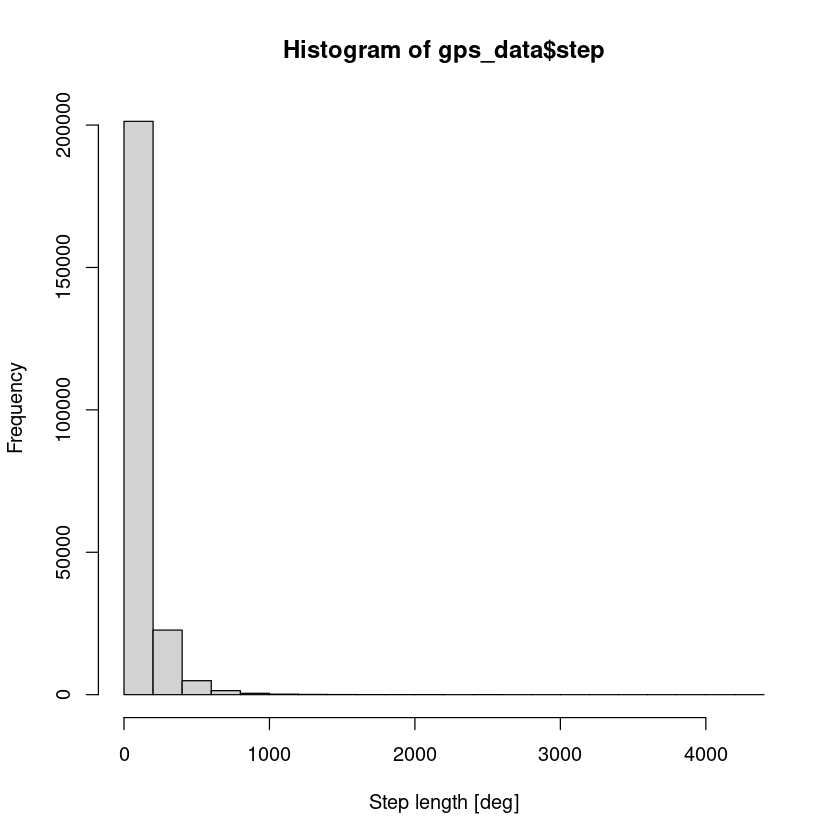

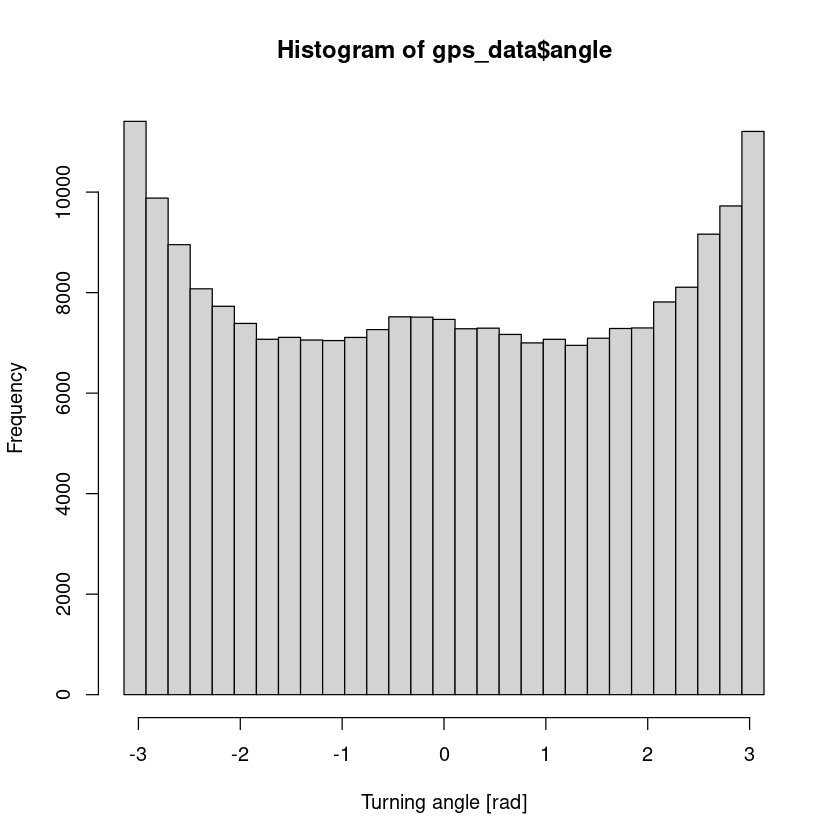

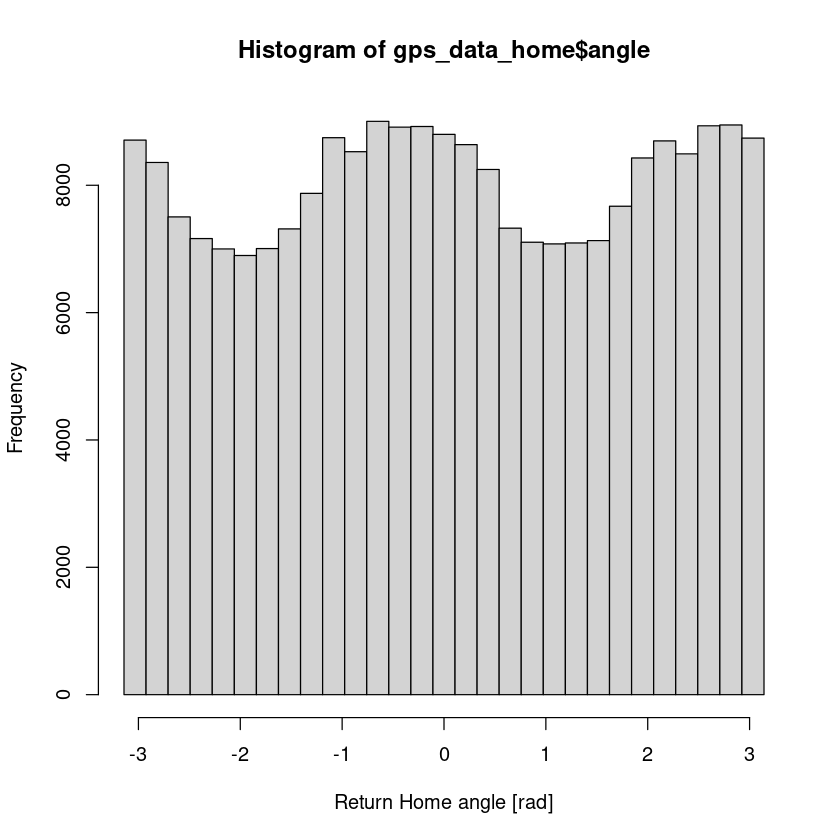

In [9]:
hist(gps_data$step, xlab = "Step length [deg]")
hist(gps_data$angle, breaks = seq(-pi, pi, length = 30), xlab = "Turning angle [rad]")
hist(gps_data_home$angle, breaks = seq(-pi, pi, length = 30), xlab = "Return Home angle [rad]") 

## Some Different HMM Models:


### Simple 2 State Model
No covariates, 2 states.

When fitting a new model the initial parameters are VERY important. Values not close to the end results may prevent the model from converging or settling on a local minima. 

In [10]:
# Weibull Params
shape <- c(1.0, 1.3)
scale <- c(150, 30)

#Cauchy params  FOR RETURN HOME ANGLE
mean <- c(-0.13, 3.0)
concentration <- c(0.04, 0.24)

zero_mass0 <- c(0.01, 0.01)
#if we have duplicates (step-length zero) the first zero_mass should not be zero
stepPar_simple <- c(shape,scale,zero_mass0)
anglePar_simple<- c(mean,concentration)

In [11]:
model_simple <- fitHMM(data = gps_data_simple, 
               nbStates = 2, 
               stepDist = 'weibull',
               angleDist = 'wrpcauchy', 
               stepPar0 = stepPar_simple, 
               anglePar0 = anglePar_simple 
                  )

model_simple

Warning message in rbind(parts$upper, chars$ellip_v, parts$lower, deparse.level = 0L):
“number of columns of result is not a multiple of vector length (arg 2)”
Warning message in rbind(parts$upper, chars$ellip_v, parts$lower, deparse.level = 0L):
“number of columns of result is not a multiple of vector length (arg 2)”
Warning message in rbind(parts$upper, chars$ellip_v, parts$lower, deparse.level = 0L):
“number of columns of result is not a multiple of vector length (arg 2)”


Value of the maximum log-likelihood: -1671793 

Step length parameters:
----------------------
               state 1      state 2
shape     1.041134e+00 1.357803e+00
scale     1.465244e+02 2.900054e+01
zero-mass 1.239168e-06 6.682292e-05

Turning angle parameters:
------------------------
                  state 1   state 2
mean          -0.12704320 3.1176960
concentration  0.03997021 0.2311387

Regression coeffs for the transition probabilities:
--------------------------------------------------
             1 -> 2    2 -> 1
intercept -1.138212 -0.829216

Transition probability matrix:
-----------------------------
          [,1]      [,2]
[1,] 0.7573513 0.2426487
[2,] 0.3038109 0.6961891

Initial distribution:
--------------------
[1] 0.5677461 0.4322539

Decoding states sequence... DONE


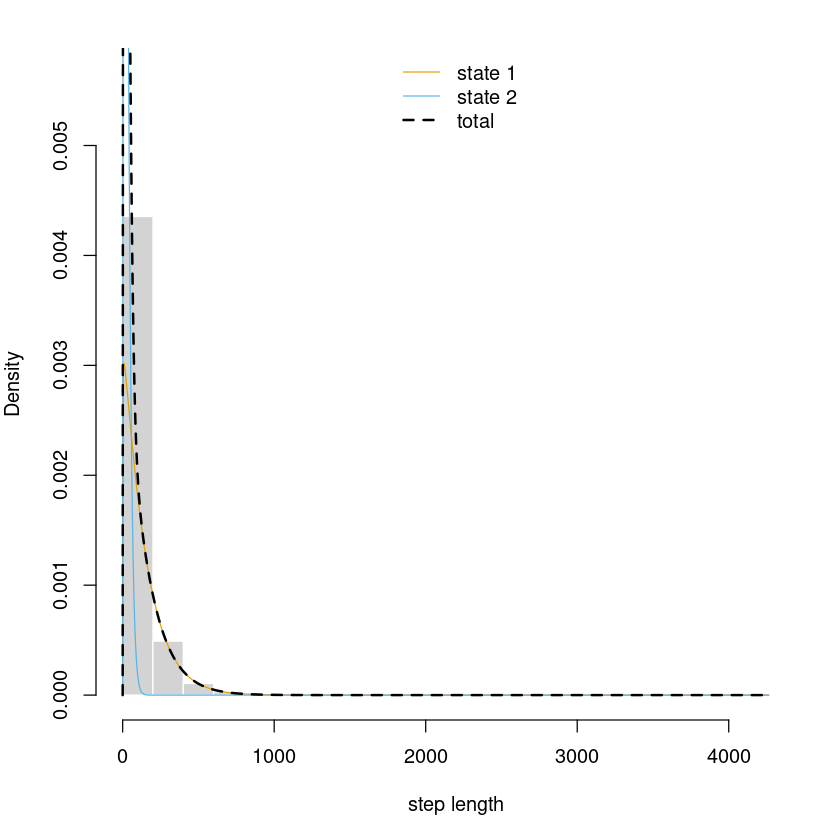

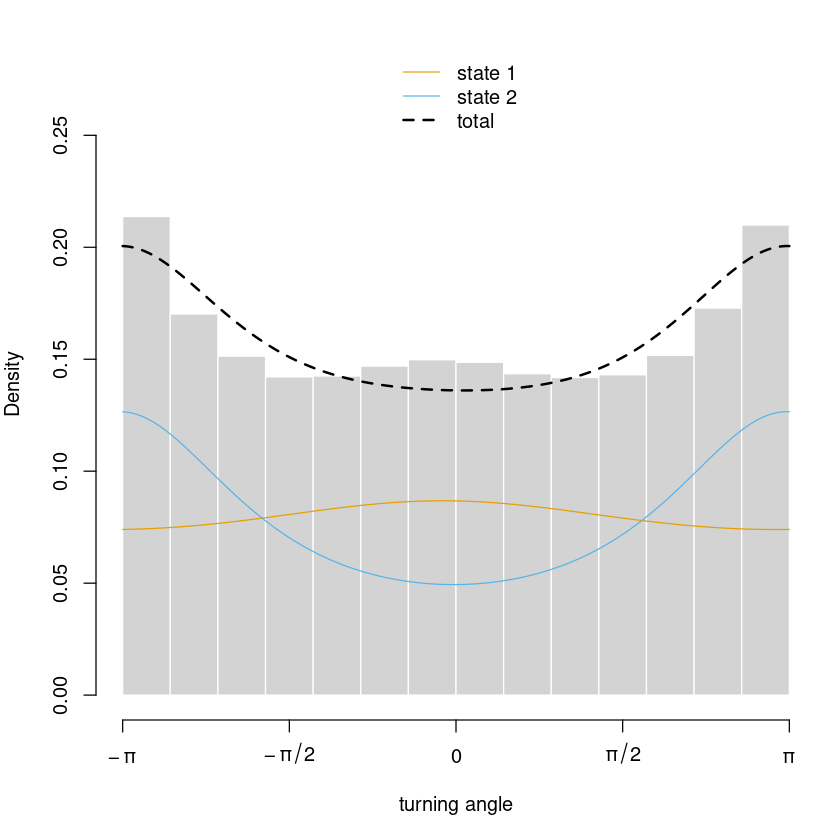

In [12]:
plot(model_simple, ask = FALSE, plotTracks = FALSE, plotCI = TRUE)

## 2 State Model, Landscape included


In [13]:
# Weibull Params
shape <- c(1.0, 1.3)
scale <- c(150, 30)

#Cauchy params  FOR RETURN HOME ANGLE
mean <- c(-0.13, 3.0)
concentration <- c(0.04, 0.24)

zero_mass0 <- c(0.01, 0.01)
#if we have duplicates (step-length zero) the first zero_mass should not be zero
stepPar1 <- c(shape,scale,zero_mass0)
anglePar1<- c(mean,concentration)

In [14]:
mod_simple_landscape <- fitHMM(data = gps_data, 
               nbStates = 2, 
               stepDist = 'weibull',
               angleDist = 'wrpcauchy', 
               stepPar0 = stepPar1, 
               anglePar0 = anglePar1,
               formula=~raster_value)


Decoding states sequence... DONE


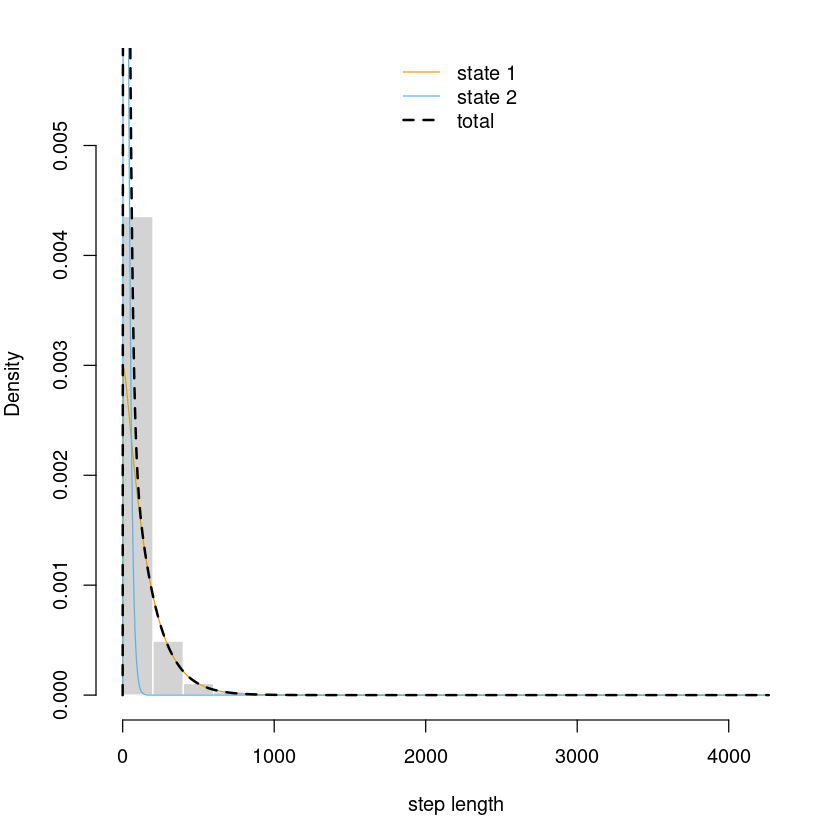

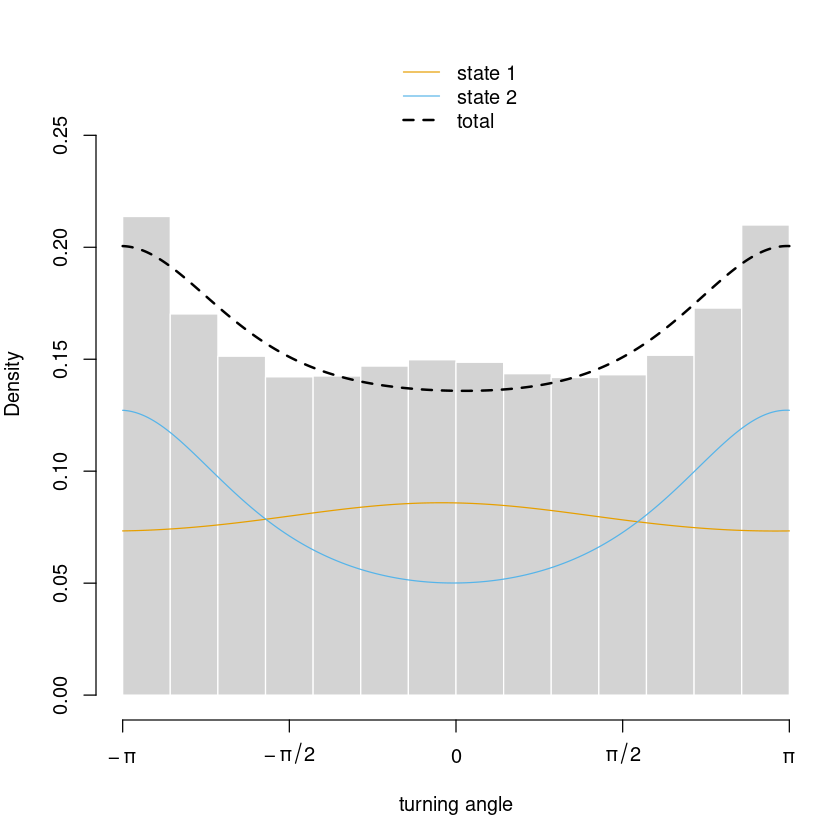

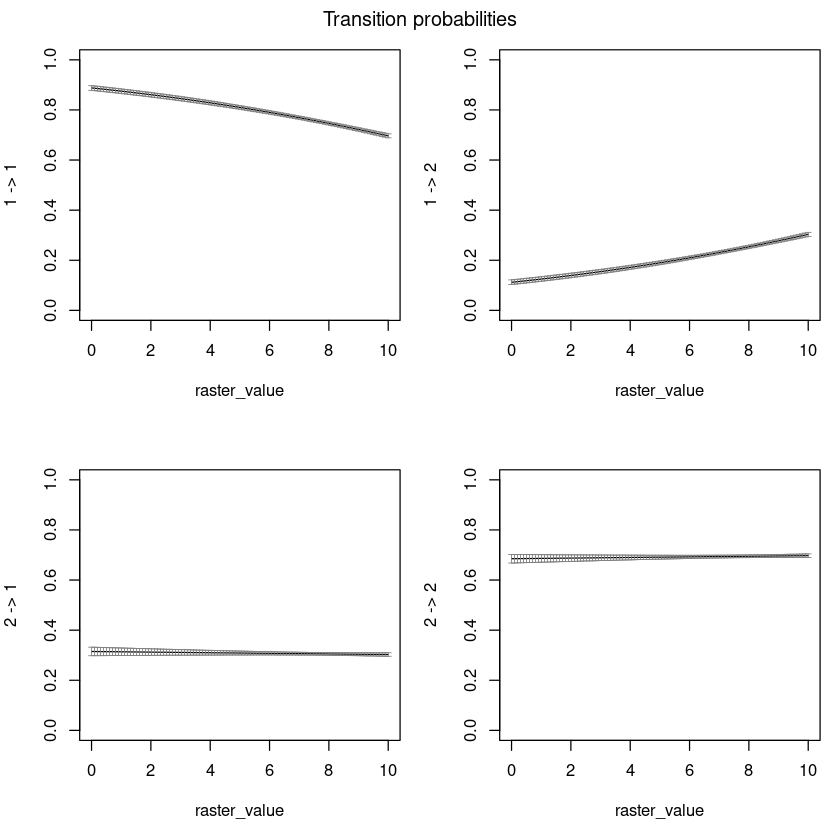

In [15]:
plot(mod_simple_landscape, ask = FALSE, plotTracks = FALSE, plotCI = TRUE)

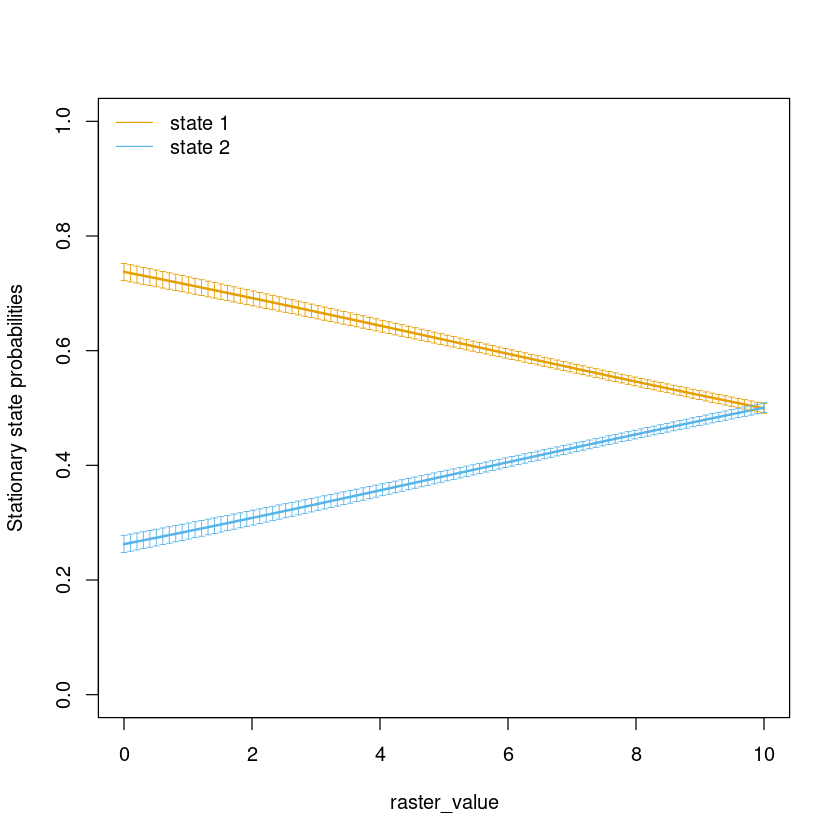

In [16]:
plotStationary(mod_simple_landscape, plotCI=TRUE)

In [40]:
mod_simple_landscape

Value of the maximum log-likelihood: -1671429 

Step length parameters:
----------------------
               state 1      state 2
shape     1.042846e+00 1.356711e+00
scale     1.471591e+02 2.911879e+01
zero-mass 7.851724e-06 5.814130e-05

Turning angle parameters:
------------------------
                 state 1   state 2
mean          -0.1339658 3.1166163
concentration  0.0396948 0.2290252

Regression coeffs for the transition probabilities:
--------------------------------------------------
                 1 -> 2       2 -> 1
intercept    -2.0696753 -0.777699801
raster_value  0.1238317 -0.005702054

Initial distribution:
--------------------
[1] 0.5663704 0.4336296

# HMM numbers to stick into Repast Model
The HMM numbers that are needed for the Repast model. This gets stuck into the python model:

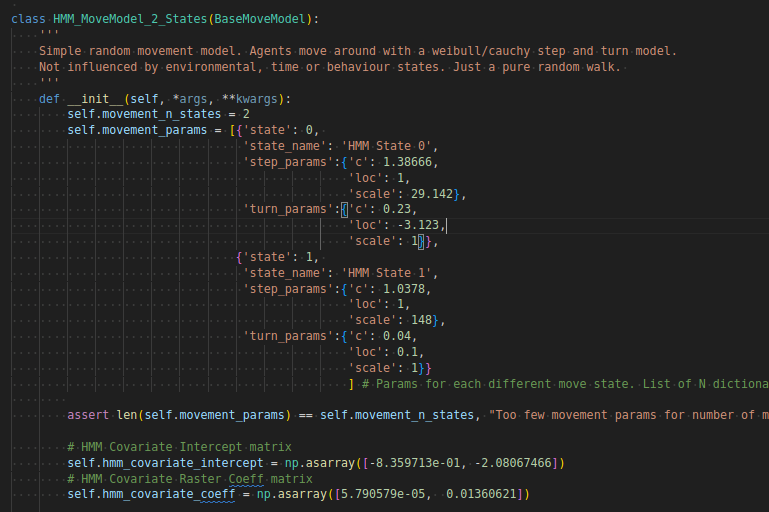


In [18]:
mod_simple_landscape

Value of the maximum log-likelihood: -1671429 

Step length parameters:
----------------------
               state 1      state 2
shape     1.042846e+00 1.356711e+00
scale     1.471591e+02 2.911879e+01
zero-mass 7.851724e-06 5.814130e-05

Turning angle parameters:
------------------------
                 state 1   state 2
mean          -0.1339658 3.1166163
concentration  0.0396948 0.2290252

Regression coeffs for the transition probabilities:
--------------------------------------------------
                 1 -> 2       2 -> 1
intercept    -2.0696753 -0.777699801
raster_value  0.1238317 -0.005702054

Initial distribution:
--------------------
[1] 0.5663704 0.4336296

## 3 State Model, Landscape included

In [19]:
# Weibull Params
shape <- c(1.0, 1.3)
scale <- c(150, 30)

#Cauchy params  FOR RETURN HOME ANGLE
mean <- c(-0.13, 3.0)
concentration <- c(0.04, 0.24)


In [20]:
# Weibull Params
shape <- c(1.2, 1.1, 1.0)
scale <- c(150, 30, 10)

#Cauchy params
mean <- c(0, -0.21, -3)
concentration <- c(0.04, 0.24, 0.1)

zero_mass0 <- c(0.01,0.01,0.01)
#if we have duplicates (step-length zero) the first zero_mass should not be zero
stepPar2 <- c(shape,scale,zero_mass0)
anglePar2<- c(mean,concentration)

In [21]:
mod_3states <- fitHMM(data = gps_data, 
               nbStates = 3, 
               stepDist = 'weibull',
               angleDist = 'wrpcauchy',
               stepPar0 = stepPar2, 
               anglePar0 = anglePar2,
               formula=~raster_value
                     )

mod_3states

Value of the maximum log-likelihood: -1667111 

Step length parameters:
----------------------
               state 1      state 2      state 3
shape     1.311337e+00 1.231843e+00 1.470787e+00
scale     3.351919e+02 1.132833e+02 2.408109e+01
zero-mass 1.231680e-06 4.520232e-07 7.615968e-05

Turning angle parameters:
------------------------
                  state 1     state 2   state 3
mean          -0.06124627 -3.07373644 3.1127951
concentration  0.21499672  0.04074727 0.2042132

Regression coeffs for the transition probabilities:
--------------------------------------------------
                  1 -> 2      1 -> 3      2 -> 1      2 -> 3     3 -> 1
intercept    -1.61019298 -1.62130884 -1.79254789 -1.72515496 -2.2150039
raster_value  0.09487647  0.09543828 -0.08549171  0.09086488 -0.1138435
                   3 -> 2
intercept    -0.665865790
raster_value  0.006435542

Initial distribution:
--------------------
[1] 0.1190081 0.4928453 0.3881465

Decoding states sequence... DONE


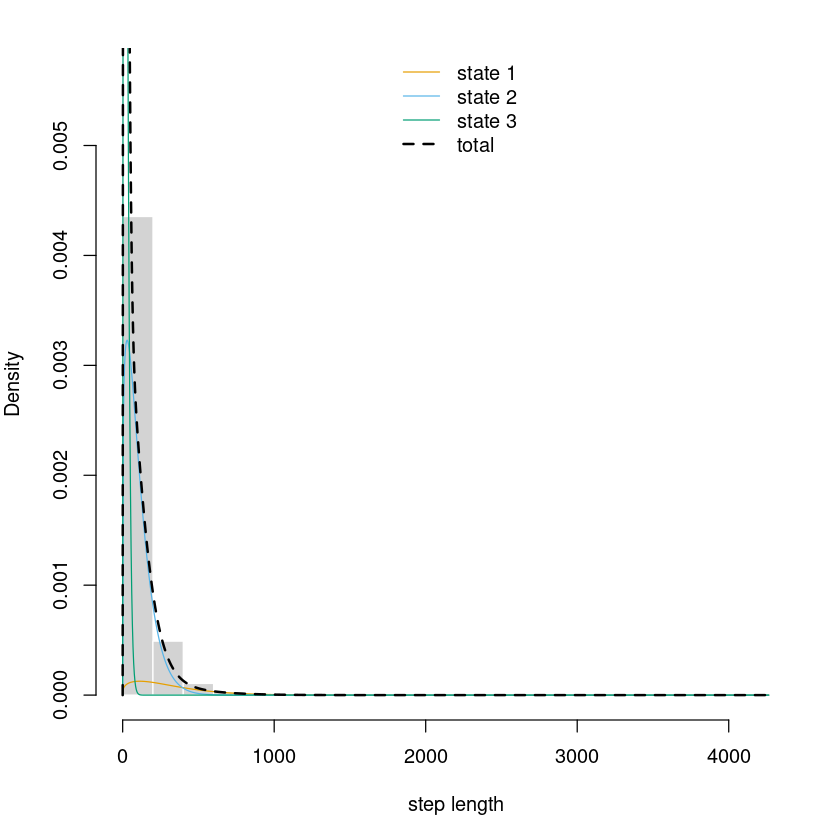

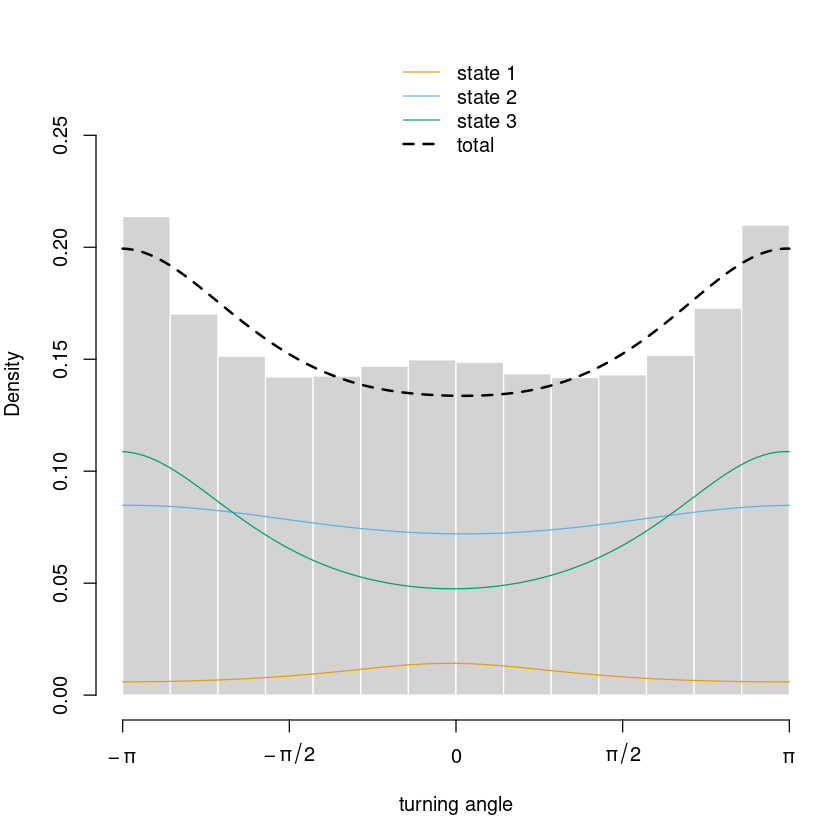

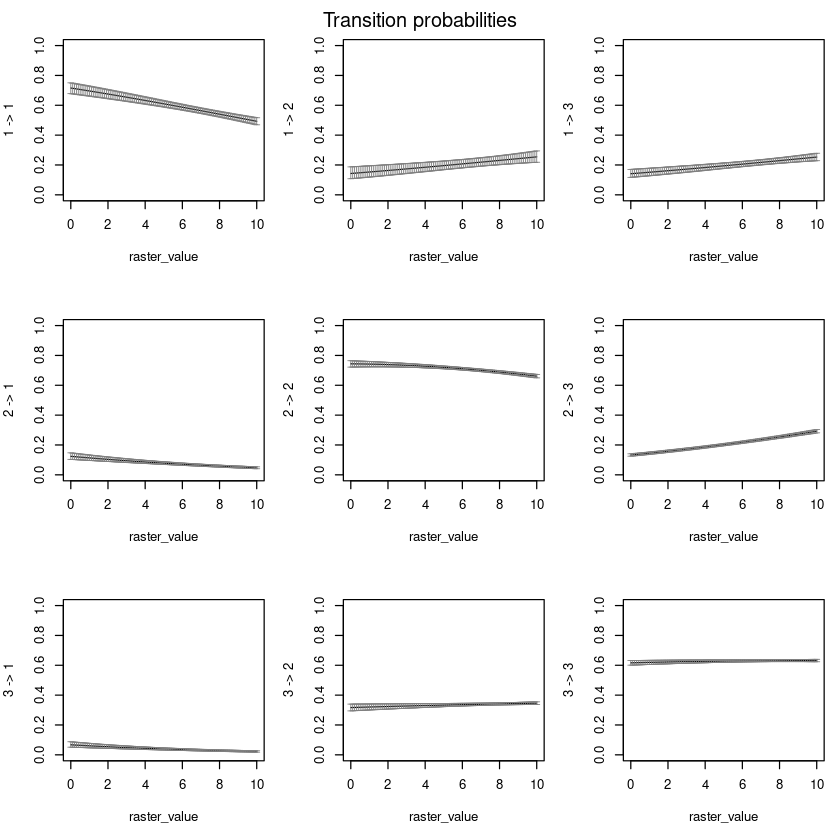

In [22]:
plot(mod_3states, ask = FALSE, plotTracks = FALSE, plotCI = TRUE)

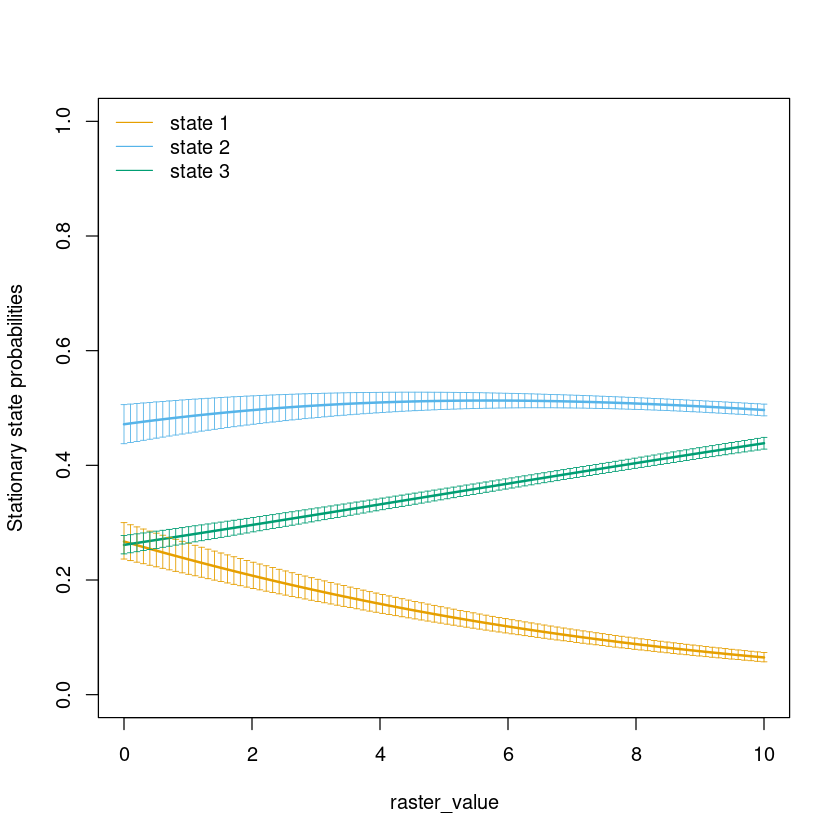

In [23]:
plotStationary(mod_3states, plotCI=TRUE)

In [35]:
mod_3states$mle 

$stepPar
               state 1      state 2      state 3
shape     1.311337e+00 1.231843e+00 1.470787e+00
scale     3.351919e+02 1.132833e+02 2.408109e+01
zero-mass 1.231680e-06 4.520232e-07 7.615968e-05

$anglePar
                  state 1     state 2   state 3
mean          -0.06124627 -3.07373644 3.1127951
concentration  0.21499672  0.04074727 0.2042132

$beta
                  1 -> 2      1 -> 3      2 -> 1      2 -> 3     3 -> 1
intercept    -1.61019298 -1.62130884 -1.79254789 -1.72515496 -2.2150039
raster_value  0.09487647  0.09543828 -0.08549171  0.09086488 -0.1138435
                   3 -> 2
intercept    -0.665865790
raster_value  0.006435542

$delta
[1] 0.1190081 0.4928453 0.3881465

In [ ]:
# Fixed values for other covariates (temperature)
temp_fixed <- c(10, 20)
# Design matrix for temp = 10
newcovs1 <- cbind("intercept" = 1,
"dist_water" = dist_water_grid,
"temp" = temp_fixed[1],
"dist_water:temp" = dist_water_grid * temp_fixed[1])

In [39]:
moveHMM:::trMatrix_rcpp(nbStates = 2,beta = mod_3states$mle$beta, covs = mod_3states$mle$delta)

ERROR: Error: Not a matrix.


## 3-States Return Home Model

In [25]:
# Weibull Params
shape <- c(1.2, 1.1, 1.0)
scale <- c(150, 30, 10)

#Cauchy params
mean <- c(0, -0.21, -3)
concentration <- c(0.04, 0.24, 0.1)

zero_mass0 <- c(0.01,0.01,0.01)
#if we have duplicates (step-length zero) the first zero_mass should not be zero
stepPar2 <- c(shape,scale,zero_mass0)
anglePar2<- c(mean,concentration)

In [26]:
mod_3states_rh <- fitHMM(data = gps_data_home, 
               nbStates = 3, 
               stepDist = 'weibull',
               angleDist = 'wrpcauchy',
               stepPar0 = stepPar2, 
               anglePar0 = anglePar2,
               formula=~raster_value)

mod_3states_rh

Value of the maximum log-likelihood: -1678211 

Step length parameters:
----------------------
               state 1      state 2      state 3
shape     1.362284e+00 1.250077e+00 1.482404e+00
scale     3.482021e+02 1.128641e+02 2.354635e+01
zero-mass 1.584039e-08 8.117776e-08 7.634298e-05

Turning angle parameters:
------------------------
                  state 1    state 2     state 3
mean          -0.52726790 1.39373442 -1.44555407
concentration  0.02795376 0.01007978  0.00430416

Regression coeffs for the transition probabilities:
--------------------------------------------------
                  1 -> 2      1 -> 3      2 -> 1      2 -> 3     3 -> 1
intercept    -1.45952848 -1.69687478 -1.74283048 -1.64202991 -2.2482265
raster_value  0.09671771  0.09961845 -0.09084072  0.08628029 -0.1039305
                   3 -> 2
intercept    -0.577809493
raster_value  0.001308924

Initial distribution:
--------------------
[1] 0.1158054 0.4998902 0.3843044

Decoding states sequence... DONE


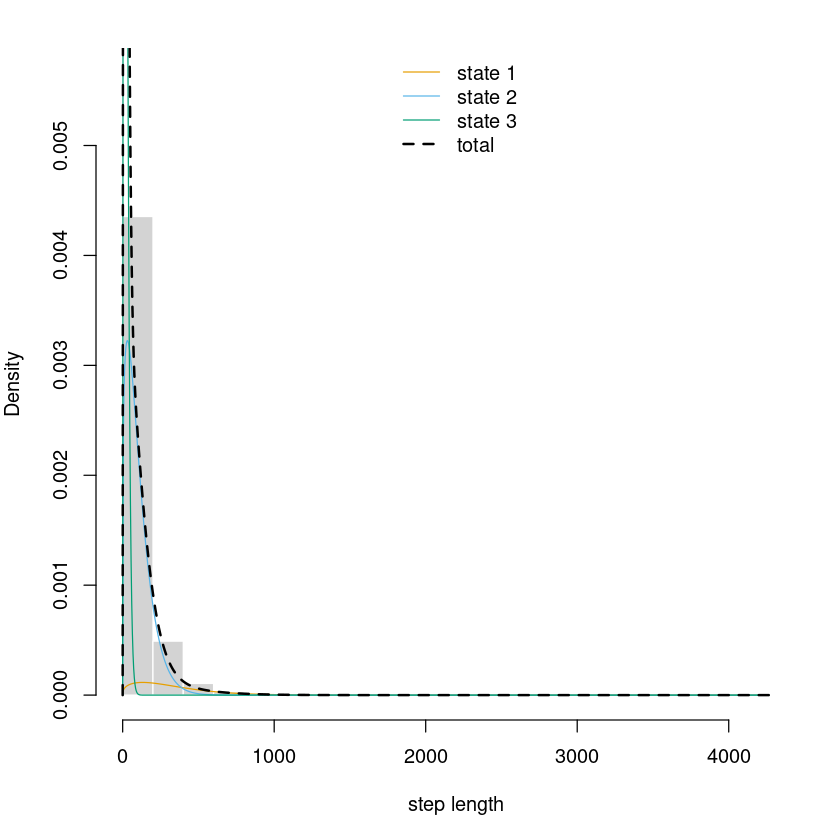

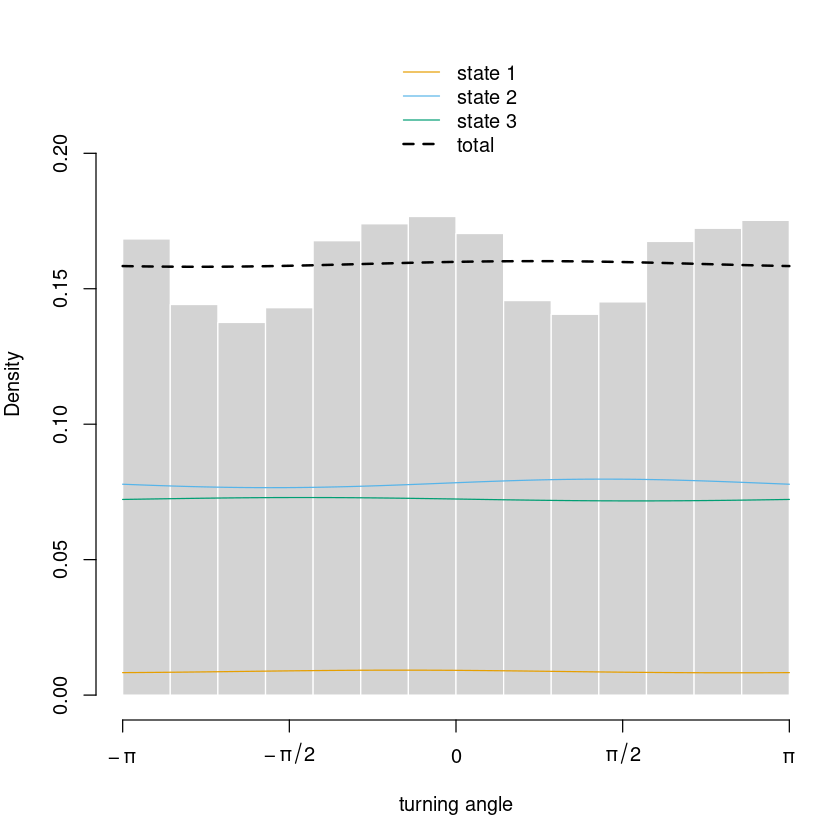

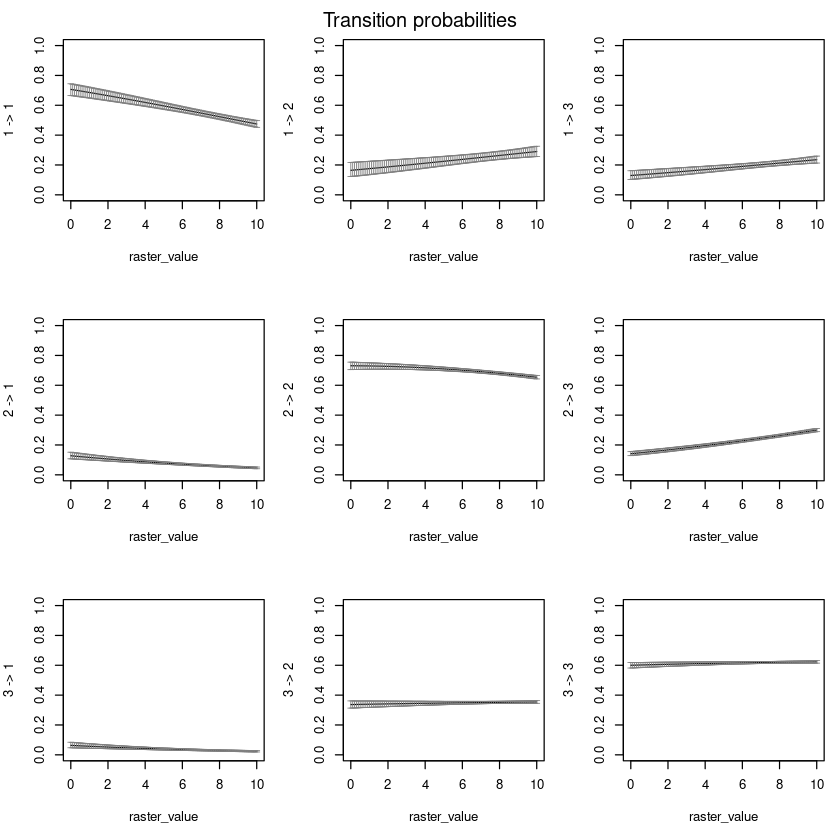

In [27]:
plot(mod_3states_rh, ask = FALSE, plotTracks = FALSE, plotCI = TRUE)

## But which is best?

Use the AIC values to decide which model is best. 

In [28]:
AIC(model_simple, mod_simple_landscape, mod_3states, mod_3states_rh)

Model,AIC
<chr>,<dbl>
mod_3states,3334279
mod_simple_landscape,3342887
model_simple,3343613
mod_3states_rh,3356480


Looks like the 3 state model performs the best, while the "return home" model is the worst.

In [32]:
## Export this notebook to HTML and then to pdf 
! jupyter nbconvert --no-input  --embed-images --to webpdf '02-HMM R-Script.ipynb'

ERROR: Error in parse(text = input): <text>:2:11: unexpected symbol
1: ## Export this notebook to HTML and then to pdf 
2: ! jupyter nbconvert
             ^
